# Alignment of Spatial Genomics and Histology Data

In [101]:
import math
import time
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import style
import paste as pst
import ot
import sys
import anndata
import shutil
import imageio
import scipy.linalg as linalg
import scipy.special as scsp
import scipy.io as scio
sys.path.append("../PASTEsrc/")
from helper import intersect, kl_divergence_backend, to_dense_array, extract_data_matrix
import random
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Read data and create AnnData object

In [102]:
data_dir = '../sample_data/' 
# Assume that the coordinates of slices are named slice_name + "_coor.csv"
def load_slices(data_dir, slice_names=["slice1", "slice2", "slice3", "slice4"]):
    slices = []  
    for slice_name in slice_names:
        slice_i = sc.read_csv(data_dir + slice_name + ".csv")
        slice_i_coor = np.genfromtxt(data_dir + slice_name + "_coor.csv", delimiter = ',')
        slice_i.obsm['spatial'] = slice_i_coor
        # Preprocess slices
        sc.pp.filter_genes(slice_i, min_counts = 15)
        sc.pp.filter_cells(slice_i, min_counts = 100)
        slices.append(slice_i)
    return slices

slices = load_slices(data_dir)
slice1, slice2, slice3, slice4 = slices

## Visualize the slices

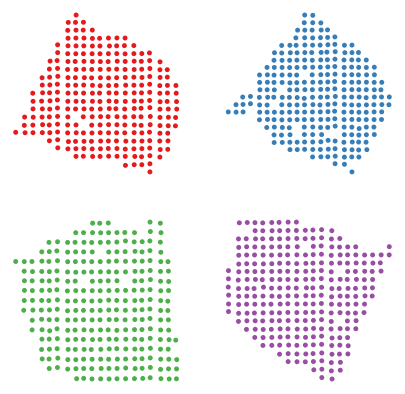

In [103]:
slice_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']

fig, axs = plt.subplots(2, 2,figsize=(7,7))
pst.plot_slice(slice1,slice_colors[0],ax=axs[0,0])
pst.plot_slice(slice2,slice_colors[1],ax=axs[0,1])
pst.plot_slice(slice3,slice_colors[2],ax=axs[1,0])
pst.plot_slice(slice4,slice_colors[3],ax=axs[1,1])
plt.show()

# Some functions for alignment

### RANSAC method

In [104]:
def get_model_from_sample(Xt, Yt, rand_sample):
    R, t, s = get_model_from_inliers(Xt, Yt, np.array(rand_sample))
    if s < 0.8 or s > 1.5:
        return np.identity(2), np.zeros((2,1)), False
    return R, t, True

def get_model_from_inliers(Xt, Yt, inliers):
    if inliers.shape[0] == 2:
        y_tilde, x_tilde = np.expand_dims(Yt[:,inliers[0]] - Yt[:,inliers[1]],-1), np.expand_dims(Xt[:,inliers[0]] - Xt[:,inliers[1]],-1)
        s = np.sqrt((y_tilde.T @ y_tilde) / (x_tilde.T @ x_tilde))
        if s < 0.8 or s > 1.5: 
            return np.identity(2), np.zeros((2,1)), s
    X_I = Xt[:,inliers]
    Y_I = Yt[:,inliers]
    muX = np.expand_dims(np.mean(X_I,axis = 1),-1)
    muY = np.expand_dims(np.mean(Y_I,axis = 1),-1)
    X_N = X_I - muX
    Y_N = Y_I - muY
    S = np.dot(X_N,Y_N.T)
    U,sigma,VT = np.linalg.svd(S)
    R = VT.T@U.T
    t = muY - R@muX
    # the rotation matrix may have ambiguity
    if np.linalg.det(R)<0:
        R = np.diag([-1,1])@R
    return R, t, 1

def evaluate_model(Xt, Yt, R, t, inlier_threshold):
    Y_hat = R@Xt + t
    error = np.sqrt(np.sum(np.power(Y_hat - Yt,2),axis=0))
    inliers = np.where(error < inlier_threshold)[0]
    support = inliers.shape[0]
    return support, inliers

def polish_model(Xt, Yt, inliers, inlier_threshold):
    # performing iterative least squares
    for iter in range(5):
        R, t, _ = get_model_from_inliers(Xt, Yt, inliers)
        _, inliers = evaluate_model(Xt, Yt, R, t, inlier_threshold)
    return inliers, R, t

def RANSAC(X, Y, max_iter = 5000, inlier_threshold = 1, confidence = 0.99):
    # initialize parameters
    best_support = 0
    current_trail = 0
    N = X.shape[0]
    Xt, Yt = X.T, Y.T
    while current_trail < max_iter:
        current_trail = current_trail + 1
        # randomly choose two sample from putative matches
        rand_sample = random.sample(range(N),2)
        # calculate a rigid model from the two sample
        current_R, current_t, continue_flag = get_model_from_sample(Xt, Yt, rand_sample)
        # fast reject the bad model if the scaling value is deviated far from 1 
        if not continue_flag:
            continue
        # evaluate the model
        current_support, current_inliers = evaluate_model(Xt, Yt, current_R, current_t, inlier_threshold)
        # update so-far-the-best model
        if current_support > best_support:
            best_support = current_support
            best_R, best_t, best_inliers = current_R, current_t, current_inliers
            # update max iteration
            max_iter = min(math.log(1-confidence)/math.log(1-pow((best_inliers.shape[0]/N),2)),max_iter)
    best_inliers, best_R, best_t = polish_model(Xt, Yt, best_inliers, inlier_threshold)
    print('Iter: ' + str(current_trail) + ', Inliers: ' + str(best_inliers.shape[0]))
    return best_inliers, best_R, best_t

def establish_putative_matches(sliceA, sliceB, nearest_neighbor = 1, mutual = False):
    backend = ot.backend.NumpyBackend()
    nx = backend
    common_genes = intersect(sliceA.var.index, sliceB.var.index)
    sliceA = sliceA[:, common_genes] # get common genes
    sliceB = sliceB[:, common_genes]
    coordinatesA = sliceA.obsm['spatial'].copy()
    coordinatesB = sliceB.obsm['spatial'].copy()
    A_X, B_X = nx.from_numpy(to_dense_array(extract_data_matrix(sliceA,None))), nx.from_numpy(to_dense_array(extract_data_matrix(sliceB,None)))
    # calculate gene expression distance matrix using Euclidean distance
    M_matrix = ot.dist(A_X,B_X) 

    MsortIndex = np.argsort(M_matrix, axis = 1) # sort the similarity to obtain the most similarity one
    X = coordinatesA
    Y = coordinatesB[MsortIndex[:,0],:]
    # for the case that the required nearest neighbor is bigger than 1
    for i in range(1,nearest_neighbor):
        X = np.concatenate((X,coordinatesA),axis = 0)
        Y = np.concatenate((Y,coordinatesB[MsortIndex[:,i],:]),axis=0)
    # mutual check, i.e., mutual nearest neighbor
    if mutual:
        MsortIndex = np.argsort(M_matrix, axis = 0)
        for i in range(1,nearest_neighbor):
            X = np.concatenate((X,coordinatesA[MsortIndex[i,:],:]),axis = 0)
            Y = np.concatenate((Y,coordinatesB),axis=0)
    return X, Y

def plot_putative_matches(sliceA, sliceB, X, Y, ax, color1, color2, spot_size = 10):
    coordinatesA = sliceA.obsm['spatial'].copy()
    coordinatesB = sliceB.obsm['spatial'].copy()
    translation = 30
    plot_marker_size = 1
    sns.scatterplot(x = coordinatesA[:,0],y = coordinatesA[:,1],linewidth=0,s=spot_size, marker=".",color=color1,ax=ax)
    sns.scatterplot(x = translation + coordinatesB[:,0],y = coordinatesB[:,1],linewidth=0,s=spot_size, marker=".",color=color2,ax=ax)
    # for i in range(coordinatesA.shape[0]):
    #     plt.plot(coordinatesA[i,0],coordinatesA[i,1],"o",color = color1, markersize=plot_marker_size)
    # for i in range(coordinatesB.shape[0]):
    #     plt.plot(translation+coordinatesB[i,0],coordinatesB[i,1],"o",color = color2, markersize=plot_marker_size)
    for i in range(X.shape[0]):
        ax.plot([X[i,0],translation+Y[i,0]],[X[i,1],Y[i,1]],color="k",linewidth=1,alpha=0.2)

def transform(Y, R, t, s=1):
    return np.transpose(s * np.dot(R, Y.T) + t)

def RANSAC_alignment_slices(
    sliceA: anndata.AnnData,
    sliceB: anndata.AnnData,
    max_iter: int = 5000,
    inlier_threshold: float = 1,
    confidence: float = 0.99,
    nearest_neighbor: int = 1,
    mutual: bool = True
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    # establish the putative matches according only on the gene espression similarity 
    X, Y = establish_putative_matches(sliceA, sliceB, nearest_neighbor = nearest_neighbor, mutual = True)
    # perform the RANSAC to robustly estimate the transformation model
    inliers, R, t = RANSAC(X, Y, max_iter = max_iter, inlier_threshold = inlier_threshold, confidence = confidence)
    
    return inliers, X, Y, R, t


### Gaussian process regression with outliers method
3 modes: S: similarity, N: nonrigid, SN: similarity + nonrigid

In [105]:


def generate_gif_from_jpg(path='./__TEMP__/',savename='./output.gif'):
    file_names = os.listdir(path)
    frames = []
    for i in range(len(file_names)):
        frames.append(imageio.imread(f'./__TEMP__/{i}.jpg'))
    imageio.mimsave(savename, frames, 'GIF', duration=0.3)

def con_K(
    X: np.ndarray,
    Y: np.ndarray,
    beta: float
):
    """
    con_K constructs the RBF kernel, where K(i,j)=k(X_i,Y_j)=exp(-beta*||X_i-Y_j||^2).

    """
    # dimension should be the same
    assert X.shape[1] == Y.shape[1]
    K = np.expand_dims(X, axis=1) - np.expand_dims(Y, axis=0)
    K = np.einsum('ijk->ij',np.einsum('ijk,ijk->ijk',K,K))
    K = np.exp(-beta*K)
    return K

def get_P(
    XnAHat: np.ndarray,
    XnB: np.ndarray,
    sigma2,
    alpha,
    gamma,
    ou,
    Sigma: np.ndarray,
    GeneDistMat,
    SpatialDistMat,
    beta2
):
    # dimension XnA and VnA should be the same
    NA, NB, D = XnAHat.shape[0], XnB.shape[0], XnAHat.shape[1]
    if D == 2:
        a = (max(XnAHat[:,0]) - min(XnAHat[:,0])) * (max(XnAHat[:,1]) - min(XnAHat[:,1]))
        b = (max(XnB[:,0]) - min(XnB[:,0])) * (max(XnB[:,1]) - min(XnB[:,1]))
    a = max(a,b)
    if len(Sigma.shape)==2:
        term1 = np.minimum(np.einsum('ij,i->ij',np.einsum('ij,ij->ij',np.exp(-SpatialDistMat/(2*sigma2)),np.exp(-GeneDistMat/(2*beta2))),(alpha*np.exp(-np.diag(Sigma)/sigma2))),1e10)
    else:
        term1 = np.minimum(np.einsum('ij,i->ij',np.einsum('ij,ij->ij',np.exp(-SpatialDistMat/(2*sigma2)),np.exp(-GeneDistMat/(2*beta2))),(alpha*np.exp(-Sigma/sigma2))),1e10)
    term2 = np.power((2*np.pi*sigma2),D/2) * np.power((2*np.pi*beta2),D/2)  * (1-gamma)  / (gamma*a) + np.einsum('ij->j',term1)
    P = term1 / np.maximum(np.expand_dims(term2,0),1e-7)
    E = 0
    return P, E

def normalize(
    X0: np.ndarray,
    Y0: np.ndarray
):
    normalize_param = {}
    assert X0.shape[1] == Y0.shape[1]
    N_X, N_Y, D = X0.shape[0], Y0.shape[0], X0.shape[1]
    normalize_param['X_mean'], normalize_param['Y_mean'] = np.einsum('ij->j',X0)/N_X, np.einsum('ij->j',Y0)/N_Y
    X0, Y0 = X0 - normalize_param['X_mean'], Y0 - normalize_param['Y_mean']
    normalize_param['X_scale'], normalize_param['Y_scale'] = np.sqrt(np.einsum('ij->',np.einsum('ij,ij->ij',X0,X0))/N_X), np.sqrt(np.einsum('ij->',np.einsum('ij,ij->ij',Y0,Y0))/N_Y)
    nX, nY = X0 / normalize_param['X_scale'], Y0 / normalize_param['Y_scale']
    return nX, nY, normalize_param

def normalizeGene(
    YA: np.ndarray,
    YB: np.ndarray
):
    normalize_param = {}
    assert YA.shape[1] == YB.shape[1]
    N_A, N_B, G = YA.shape[0], YB.shape[0], YA.shape[1]
    Y = np.concatenate((YA,YB),axis = 0)
    N = Y.shape[0]
    normalize_param['mean'] = np.einsum('ij->j',Y)/N
    Y = Y - normalize_param['mean']
    normalize_param['scale'] = np.sqrt(np.einsum('ij->',np.einsum('ij,ij->ij',Y,Y))/N)
    Yn = Y / normalize_param['scale']
    YnA, YnB = Yn[:N_A,:], Yn[N_A:,:]
    assert YnA.shape[0] == YA.shape[0]
    assert YnB.shape[0] == YB.shape[0]
    return YnA, YnB, normalize_param
    

def Denormalize(
    XnAHat: np.ndarray,
    normalize_param
):
    XAHat = XnAHat * normalize_param['Y_scale'] + normalize_param['Y_mean']
    return XAHat

def BioAlignOpt(
    sliceA: anndata.AnnData,
    sliceB: anndata.AnnData,
    conf,
    mode='SN',
    ani=False,
    viz=False
):
    if not (mode == 'S' or mode == 'N' or mode == 'SN' or mode == 'NS'):
        Warning('mode must be S or N or SN or NS!')
        return ([],[])
    if viz == True:
        if os.path.exists('./__TEMP__/'):
            shutil.rmtree('./__TEMP__/')
        os.mkdir('./__TEMP__')
        fig,ax=plt.subplots()
        sns.scatterplot(x = sliceA.obsm['spatial'][:,0],y = sliceA.obsm['spatial'][:,1],linewidth=0,s=100, marker=".",color='#e41a1c',ax=ax)
        sns.scatterplot(x = sliceB.obsm['spatial'][:,0],y = sliceB.obsm['spatial'][:,1],linewidth=0,s=100, marker=".",color='#377eb8',ax=ax)
        plt.axis('equal')
        plt.axis('off')
        plt.pause(2)    
        if ani:
            plt.savefig(f'./__TEMP__/0.jpg',dpi = 100)
    # pre-processing
    backend = ot.backend.NumpyBackend()
    nx = backend
    common_genes = intersect(sliceA.var.index, sliceB.var.index)
    sliceA = sliceA[:, common_genes] # get common genes
    sliceB = sliceB[:, common_genes]
    XA, XB = sliceA.obsm['spatial'].copy(), sliceB.obsm['spatial'].copy()
    YA, YB = nx.from_numpy(to_dense_array(extract_data_matrix(sliceA,None))), nx.from_numpy(to_dense_array(extract_data_matrix(sliceB,None)))
    assert XA.shape[1] == XB.shape[1]
    assert YA.shape[1] == YB.shape[1]
    # select some significance genes
    if conf['ExpressionFilter']:
        ExpressionData = np.concatenate((YA,YB),axis=0)
        ExpressionVar = np.var(ExpressionData,axis=0)
        EvidenceExpression = np.where(ExpressionVar > 10)[0]
        print('Evidence expression number: ', len(EvidenceExpression))
        YA, YB = YA[:,EvidenceExpression], YB[:,EvidenceExpression]
    NA, NB, D, G = XA.shape[0], XB.shape[0], XA.shape[1], YA.shape[1]
    # normalize the spatial coordinate
    [XnA, XnB, normalize_param] = normalize(XA, XB)
    # noramlize the gene
    [YnA, YnB, normalize_param_gene] = normalizeGene(YA, YB)
    # random select control points
    K = conf['K']
    Unique_Xn = np.unique(XnA, axis = 0)
    idx = random.sample(range(Unique_Xn.shape[0]), min(K, Unique_Xn.shape[0]))
    ctrl_pts = Unique_Xn[idx,:]
    # construct the kernel
    beta = conf['beta']
    lambdaVF = conf['lambdaVF']
    GammaSparse=con_K(ctrl_pts, ctrl_pts, beta)
    U = con_K(XnA, ctrl_pts, beta)
    K = ctrl_pts.shape[0]
    # initialize parameters
    kappa = NA*np.ones((NA))
    # alpha = np.ones((NA)) / NA
    alpha = np.ones((NA))
    gamma = 0.5
    VnA = np.zeros_like(XnA)
    sigma2 = np.sum(ot.dist(XnA, XnB)) / (D*NA*NB)
    beta2 = conf['beta2']
    GeneDistMat = ot.dist(YnA,YnB)
    beta2 = np.sum(GeneDistMat) / (D*NA*NB)
    MaxIter = conf['MaxIter']
    gamma_a, gamma_b = 1, 1
    iter, ou, minP, sigma2_terc, erc = 1, 0.1, 1e-5, 1, 1e-4
    SigmaDiag = np.zeros((NA))
    XnAHat, RnA = XnA, XnA
    s, t, R = 1, np.zeros((1,D)), np.zeros((D,D))
    SpatialDistMat = ot.dist(XnAHat, XnB)
    while (iter < MaxIter) and (sigma2_terc > erc):
        # Update q2(C,E)
        [P, E] = get_P(XnAHat, XnB, sigma2, alpha, gamma, ou, SigmaDiag, GeneDistMat, SpatialDistMat, beta2)
        K_NA = np.einsum('ij->i',P)
        K_NB = np.einsum('ij->j',P)

        # Update gamma
        Sp = np.einsum('ij->',P)
        # gamma = Sp / NB
        gamma = np.exp(scsp.psi(gamma_a+Sp)-scsp.psi(gamma_a+gamma_b+NB))
        if gamma > 0.99:
            gamma = 0.99
        if gamma < 0.01:
            gamma = 0.01

        # Update alpha
        alpha = np.exp(scsp.psi(kappa+K_NA)-scsp.psi(kappa*NA+Sp))*NA

        # Update VnA
        if mode == 'N':
            term1 = np.dot(linalg.pinv(sigma2*lambdaVF*GammaSparse+np.dot(U.T,np.einsum('ij,i->ij',U,K_NA))),U.T)
            SigmaDiag = sigma2 * np.einsum('ij->i',np.einsum('ij,ji->ij',U,term1))
            VnA = np.dot(U,np.dot(term1,(np.dot(P,XnB)-np.einsum('ij,i->ij',XnA,K_NA))))
        elif mode == 'NS' or mode == 'SN':
            if iter > 20:
                term1 = np.dot(linalg.pinv(sigma2*lambdaVF*GammaSparse+np.dot(U.T,np.einsum('ij,i->ij',U,K_NA))),U.T)
                SigmaDiag = sigma2 * np.einsum('ij->i',np.einsum('ij,ji->ij',U,term1))
                VnA = np.dot(U,np.dot(term1,(np.dot(P,XnB)-np.einsum('ij,i->ij',RnA,K_NA))))
        
        # Update R()
        if mode == 'S' or mode == 'NS' or mode == 'SN':
            mu_XnA, mu_VnA, mu_XnB = np.dot(K_NA,XnA)/Sp, np.dot(K_NA,VnA)/Sp, np.dot(K_NB,XnB)/Sp
            XnABar, VnABar, XnBBar = XnA - mu_XnA, VnA - mu_VnA, XnB - mu_XnB
            A = -np.dot(np.einsum('ij,i->ij',VnABar,K_NA).T-np.dot(P,XnBBar).T,XnABar)
            svdU,svdS,svdV = np.linalg.svd(A)
            C = np.identity(D)
            C[-1,-1]=np.linalg.det(np.dot(svdU,svdV))
            R = np.dot(np.dot(svdU,C),svdV)
            s = (np.einsum('ii',np.dot(A,R.T))+1)/(np.einsum('ii',np.dot(np.einsum('ij,i->ij',XnABar,K_NA).T,XnABar))+1)
            t = mu_XnB - mu_VnA - s*np.dot(mu_XnA,R.T)
            RnA = s*np.dot(XnA,R.T)+t
        XnAHat = RnA + VnA

        # Update sigma2 and beta2
        SpatialDistMat = ot.dist(XnAHat, XnB)
        sigma2_old = sigma2
        sigma2 = np.einsum('ij,ij',P,SpatialDistMat)/(D*Sp) + np.einsum('i,i',K_NA,SigmaDiag)/Sp
        beta2 = np.einsum('ij,ij',P,GeneDistMat)/(D*Sp)
        sigma2_terc = np.abs((sigma2-sigma2_old)/sigma2)
        if viz:
            ax.cla()
            sns.scatterplot(x = XnB[:,0],y = XnB[:,1],linewidth=0,s=100, marker=".",color='#377eb8',ax=ax)
            sns.scatterplot(x = XnAHat[:,0],y = XnAHat[:,1],linewidth=0,s=100, marker=".",color='#e41a1c',ax=ax)
            plt.text(np.mean(XnB[:,0]), 1.1*max(max(XnB[:,1]),max(XnAHat[:,1])), "iter: "+str(iter)+", sigma: "+str(sigma2)[:6])
            plt.axis('equal')
            plt.axis('off')
            plt.pause(1e-3)
            if ani:
                plt.savefig(f'./__TEMP__/{iter}.jpg',dpi = 100)  
        iter = iter + 1
    XAHat = Denormalize(XnAHat, normalize_param)
    return P, XAHat

In [106]:
%matplotlib
conf = {
    'ExpressionFilter':True,
    'beta':0.1,
    'lambdaVF':3,
    'MaxIter':100,
    'K':15,
    'beta2':1
}
sliceA = slice2
sliceB = slice4
viz = False
time_arr = []
start = time.time()
pi = pst.pairwise_align(sliceA, sliceB)
pis = [pi]
slices = [sliceA, sliceB]
new_slices = pst.stack_slices_pairwise(slices, pis)
runtime = time.time() - start
time_arr.append(runtime)
start = time.time()
inliers, X, Y, R, t = RANSAC_alignment_slices(sliceA, sliceB, max_iter = 50000, inlier_threshold = 2, confidence = 0.999, nearest_neighbor = 1, mutual = True)
XBHat_RANSAC = transform(sliceB.obsm['spatial'], R.T, -R.T@t, 1)
runtime = time.time() - start
time_arr.append(runtime)
start = time.time()
[_, XAHat_S] = BioAlignOpt(sliceA, sliceB, conf, mode='S', viz=viz, ani = True)
runtime = time.time() - start
time_arr.append(runtime)
if viz:
    generate_gif_from_jpg(savename = './outputS.gif')
start = time.time()
[_, XAHat_N] = BioAlignOpt(sliceA, sliceB, conf, mode='N', viz=viz, ani = True)
runtime = time.time() - start
time_arr.append(runtime)
if viz:
    generate_gif_from_jpg(savename = './outputN.gif')
start = time.time()
[_, XAHat_SN] = BioAlignOpt(sliceA, sliceB, conf, mode='SN', viz=viz, ani = True)
runtime = time.time() - start
time_arr.append(runtime)
if viz:
    generate_gif_from_jpg(savename = './outputSN.gif')


Using matplotlib backend: TkAgg
Using selected backend cpu. If you want to use gpu, set use_gpu = True.
Iter: 371, Inliers: 41
Evidence expression number:  202
Evidence expression number:  202
Evidence expression number:  202


Text(0.5, 1.0, 'BA-SN: 0.2994')

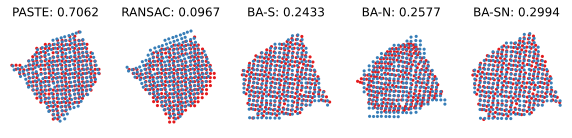

In [107]:
%matplotlib inline
slice_colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
fig, axs = plt.subplots(1, 5,figsize=(10,2))
dotsize = 40
plotIndex = 0
pst.plot_slice(new_slices[0], slice_colors[0], ax=axs[plotIndex],s=dotsize)
pst.plot_slice(new_slices[1], slice_colors[1], ax=axs[plotIndex],s=dotsize)
axs[plotIndex].axis('equal')
axs[plotIndex].set_title('PASTE: '+str(time_arr[plotIndex])[:6])

plotIndex = 1
sliceBTransformed = sliceB.copy()
sliceBTransformed.obsm['spatial'] = XBHat_RANSAC
pst.plot_slice(sliceA, slice_colors[0], ax=axs[plotIndex],s=dotsize)
pst.plot_slice(sliceBTransformed, slice_colors[1], ax=axs[plotIndex],s=dotsize)
axs[plotIndex].axis('equal')
axs[plotIndex].set_title('RANSAC: '+str(time_arr[plotIndex])[:6])

plotIndex = 2
sliceATransformed = sliceA.copy()
sliceATransformed.obsm['spatial'] = XAHat_S
pst.plot_slice(sliceATransformed, slice_colors[0], ax=axs[plotIndex],s=dotsize)
pst.plot_slice(sliceB, slice_colors[1], ax=axs[plotIndex],s=dotsize)
axs[plotIndex].axis('equal')
axs[plotIndex].set_title('BA-S: '+str(time_arr[plotIndex])[:6])

plotIndex = 3
sliceATransformed = sliceA.copy()
sliceATransformed.obsm['spatial'] = XAHat_N
pst.plot_slice(sliceATransformed, slice_colors[0], ax=axs[plotIndex],s=dotsize)
pst.plot_slice(sliceB, slice_colors[1], ax=axs[plotIndex],s=dotsize)
axs[plotIndex].axis('equal')
axs[plotIndex].set_title('BA-N: '+str(time_arr[plotIndex])[:6])

plotIndex = 4
sliceATransformed = sliceA.copy()
sliceATransformed.obsm['spatial'] = XAHat_SN
pst.plot_slice(sliceATransformed, slice_colors[0], ax=axs[plotIndex],s=dotsize)
pst.plot_slice(sliceB, slice_colors[1], ax=axs[plotIndex],s=dotsize)
axs[plotIndex].axis('equal')
axs[plotIndex].set_title('BA-SN: '+str(time_arr[plotIndex])[:6])



# plt.savefig('temp_results.svg')

